# Import crucial packages

In [1]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.optimize as sco

# Functions

In [8]:
# Similar to Figure 1 Moeira and Muir (2017) 
def analyze_by_prev_month_volatility(daily_returns_df, endofmonth, column):
    """
    Segregates months by previous month's realized volatility and computes:
        - average daily return
        - daily return variance
    for each month.
    """
    
    # Step 1: Calculate monthly realized volatility (variance of daily returns)
    monthly_vol = daily_returns_df[column].groupby(endofmonth).var()

    # Step 2: Shift to get the previous month's volatility
    prev_month_vol = monthly_vol.shift(1)

    # Step 3: Ensure proper alignment for daily data using `endofmonth`
    prev_vol_per_day = prev_month_vol.loc[endofmonth].values  # Correct reindexing

    # Step 4: Prepare the DataFrame with the necessary columns
    df = pd.DataFrame({
        'daily_return': daily_returns_df[column],
        'prev_month_vol': prev_vol_per_day, 
        'endofmonth': endofmonth,
        'month': endofmonth
    })

    # Step 5: Group by month and calculate average daily return and variance
    grouped = df.groupby('month').agg({
        'daily_return': ['mean', 'var'],
        'prev_month_vol': 'first'  # Use first value as all rows in the month share the same volatility
    })

    # Step 6: Flatten MultiIndex columns
    grouped.columns = ['avg_daily_return', 'daily_return_var', 'prev_month_vol']

    # Step 7: Sort by previous month's volatility in descending order
    result_df = grouped.sort_values('prev_month_vol', ascending=False)
    
    return result_df

In [ ]:
# Similar to Figure 1 Moeira and Muir (2017) 
def visualize_quantile_analysis(result_df):
    """
    Visualizes expected returns, realized variance, and return-to-risk ratio 
    for each quantile of previous month's realized volatility.
    """
    # Step 1: Create quantiles based on previous month vol
    result_df['vol_quintile'] = pd.qcut(result_df['prev_month_vol'], q=5, labels=False)

    # Step 2: Group by quantile and compute metrics
    summary = result_df.groupby('vol_quintile').agg({
        'avg_daily_return': 'mean',
        'daily_return_var': 'mean'
    })

    # Add return-to-variance ratio
    summary['return_to_var'] = summary['avg_daily_return'] / summary['daily_return_var']

    # Step 3: Plot all three metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # Expected Return
    axes[0].bar(summary.index, summary['avg_daily_return']*252, color='blue') #Annualize the return
    axes[0].set_title('Next months ER')
    axes[0].set_xlabel('Prev. Month Volatility Quintile (Low → High)')


    # Realized Variance
    axes[1].bar(summary.index, summary['daily_return_var']*np.sqrt(252), color='blue') # Annualize the variance
    axes[1].set_title('Next months VAR(R)')
    axes[1].set_xlabel('Prev. Month Volatility Quintile (Low → High)')


    # Return-to-Variance Ratio
    axes[2].bar(summary.index, summary['return_to_var'], color='blue')
    axes[2].set_title('Next months ER/Var(R)')
    axes[2].set_xlabel('Prev. Month Volatility Quintile (Low → High)')


    # Overall style
    for ax in axes:
        ax.grid(True, linestyle=':', linewidth=0.5, color='grey')
        ax.set_xticks(range(5))
        ax.set_xticklabels([f"Q{i+1}" for i in range(5)])

    plt.tight_layout()
    plt.show()

# Analysis

Index Futures, following Kang, J., & Kwon, K. Y. (2021). and Van Hemert et al. (2018)
We are using daily price of futures. In case of future contracts we do not need to include Risk-Free Rate

Why? Usually performace is measured in excess return, which is the return of the asset minus the risk-free rate and taking pasition in equites require fudning and pose opportunity costs.
Futures trade on margin (no opportunity cost), and the risk-free rate is already included in the futures price (reall formula).

We are using the daily settlement price of futures which are base to calculate daily margins 
similarily to Kang, J., & Kwon, K. Y. (2021)Kang, J., & Kwon, K. Y. (2021)

In [2]:
# Daily Settlement Price of Futures, data obtained from Bloomberg
daily_Price_Index_Futures = pd.read_excel("./Futures Prices.xlsx", sheet_name="INDEX PX_SETTLE").set_index("DATE")
daily_Price_Index_Futures.head(3)

# Missing values
daily_Price_Index_Futures.isna().sum()

# We are missing over 1000 values fo ST1 Index Futures (Borsa Italiana)
daily_Price_Index_Futures[-daily_Price_Index_Futures.isna().any(axis=1)].index[0]

# We are missing values from 2000-04-02 to 2004-04-02 for ST1 Index Futures

# Double check the missing values
daily_Price_Index_Futures.loc["2004-04-02":].isna().sum()
daily_Price_Index_Futures_from_2004 = daily_Price_Index_Futures.loc["2004-04-02":]

# Calculate the daily returns using formula
# Example for DAX 30: R_t = (GX2_t/ GX2_t) - 1
daily_Returns_Index_Futures = {
    "DAX": daily_Price_Index_Futures_from_2004["GX2 Index"] / daily_Price_Index_Futures_from_2004["GX1 Index"] - 1,
    "CAC 40": daily_Price_Index_Futures_from_2004["CF2 Index"] / daily_Price_Index_Futures_from_2004["CF1 Index"] - 1,
    "FTSE Athens20": daily_Price_Index_Futures_from_2004["AJ2 Index"] / daily_Price_Index_Futures_from_2004["AJ1 Index"] - 1,
    "FTSE MIB": daily_Price_Index_Futures_from_2004["ST2 Index"] / daily_Price_Index_Futures_from_2004["ST1 Index"] - 1,
    "AEX": daily_Price_Index_Futures_from_2004["EO2 Index"] / daily_Price_Index_Futures_from_2004["EO1 Index"] - 1,
    "IBEX 35": daily_Price_Index_Futures_from_2004["IB2 Index"] / daily_Price_Index_Futures_from_2004["IB1 Index"] - 1,
    "BEL 20": daily_Price_Index_Futures_from_2004["BE2 Index"] / daily_Price_Index_Futures_from_2004["BE1 Index"] - 1
}

In [3]:
daily_Returns_Index_Futures = pd.DataFrame(daily_Returns_Index_Futures, index=daily_Price_Index_Futures_from_2004.index)

In [4]:
#Basic statistics of daily return
def describe(data):
    table_data = data.describe().round(4)
    cell_text = [ [idx] + row.tolist() for idx, row in table_data.iterrows() ]
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=cell_text, colLabels=["Statistic"] + table_data.columns.tolist(), loc='center')
    plt.show()

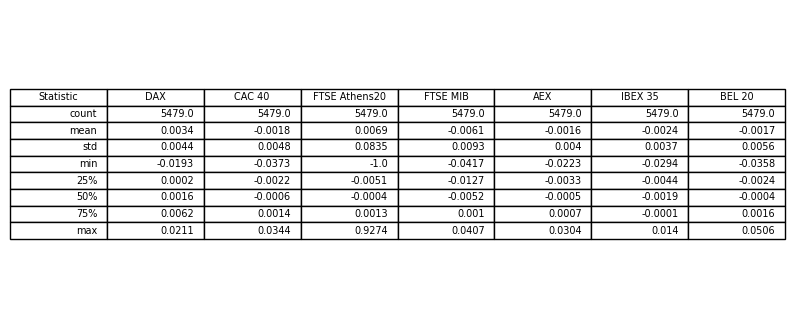

In [5]:
describe(daily_Returns_Index_Futures)

**Quantile Analysis** used in Exibit 4  Van Hemert et al. (2018) and Figure 1 Moeira and Muir (2017) 
Follwing the methodology from Moeira and Muir (2017) we need to calculate market potfolio returns 

Wiktor: I tried to calculate the market portfolio weights but results were not as expected, I need to investigate this further
How the returns are calculated


In [6]:
# Calculate monthly volatility of the returns 
endofmonth=daily_Returns_Index_Futures.index+MonthEnd(0)
monthlty_Returns_Index_Futures = (1 + daily_Returns_Index_Futures).groupby(endofmonth).prod() - 1

# Calculate monthly variance of the returns for each index
RV = daily_Returns_Index_Futures.groupby(endofmonth).var()

# Get list of shared columns
columns = monthlty_Returns_Index_Futures.columns.intersection(RV.columns)

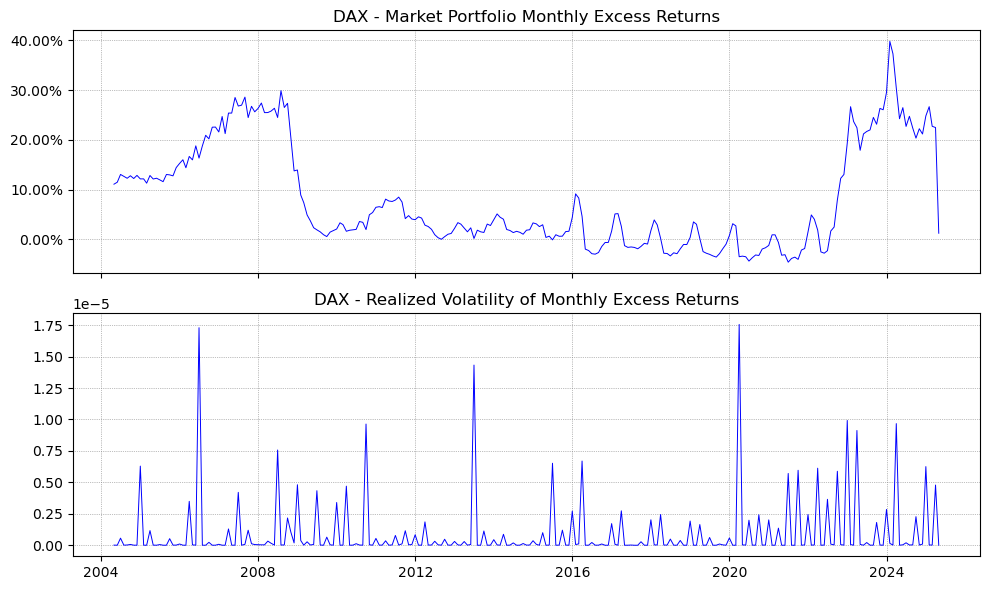

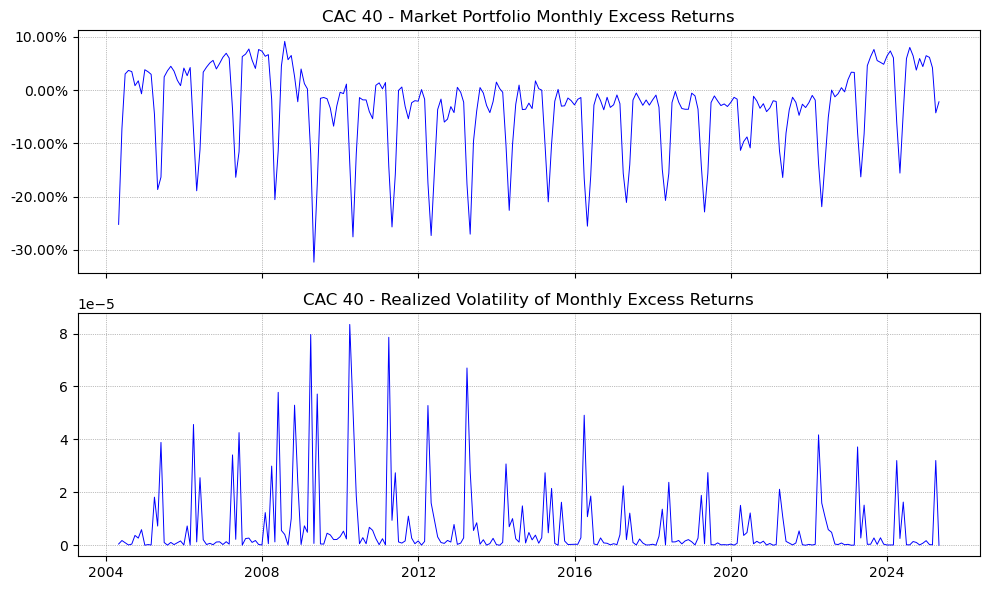

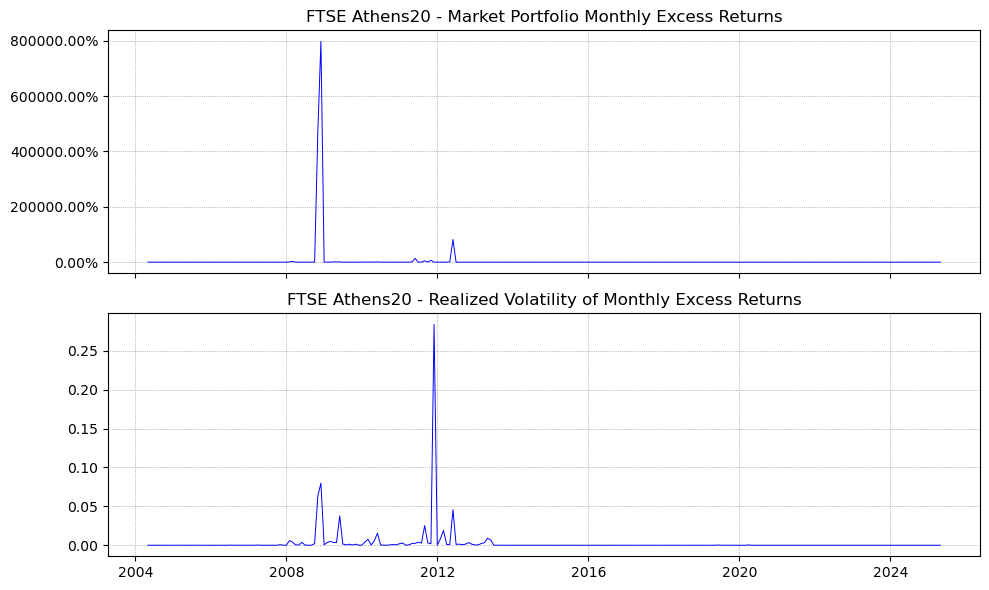

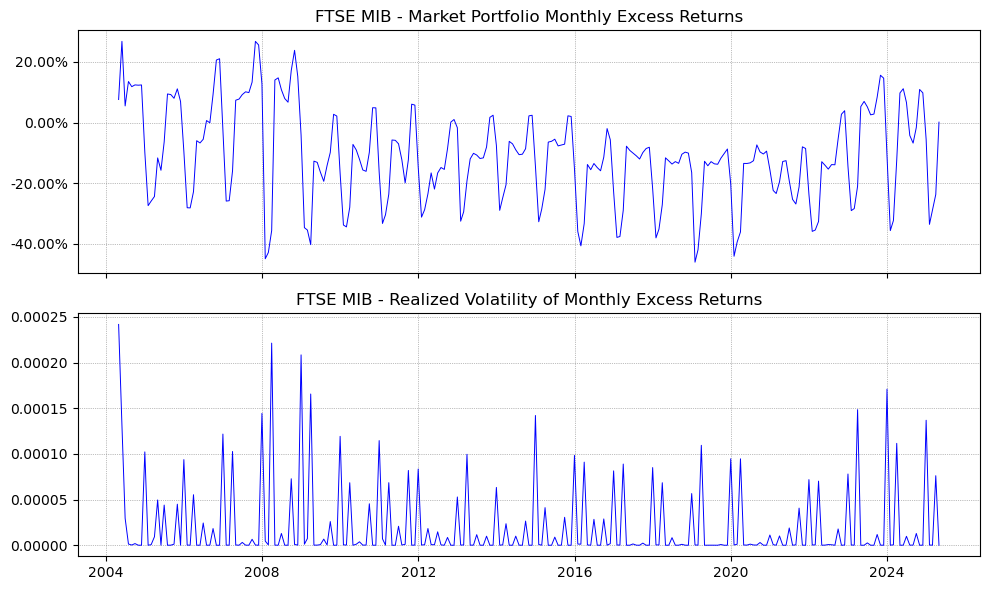

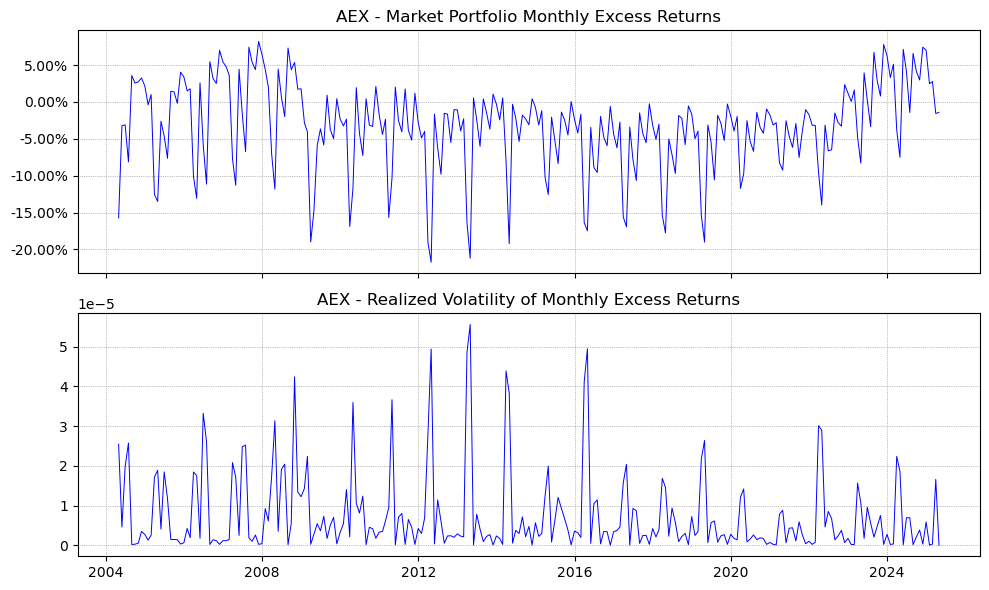

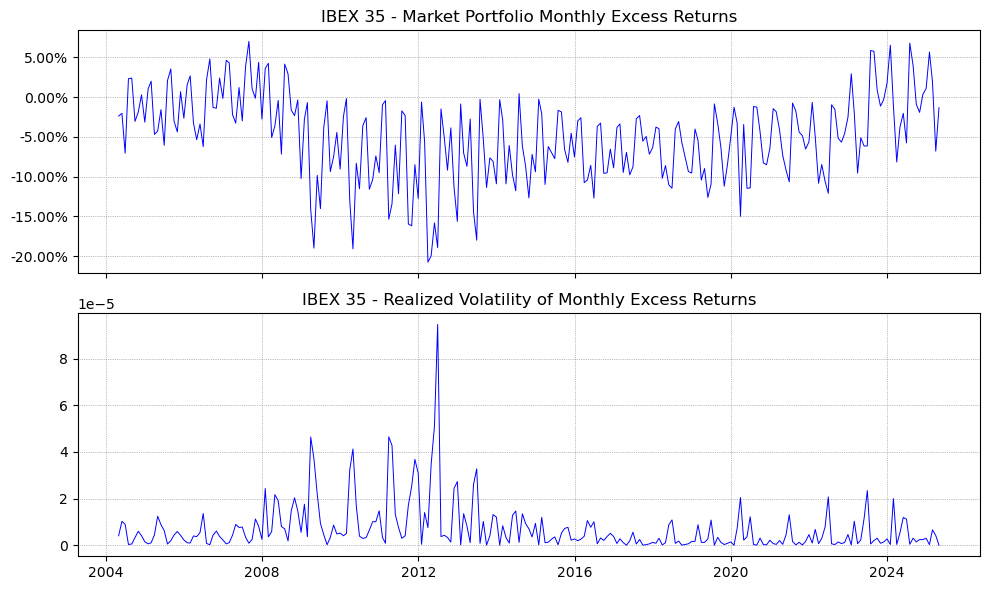

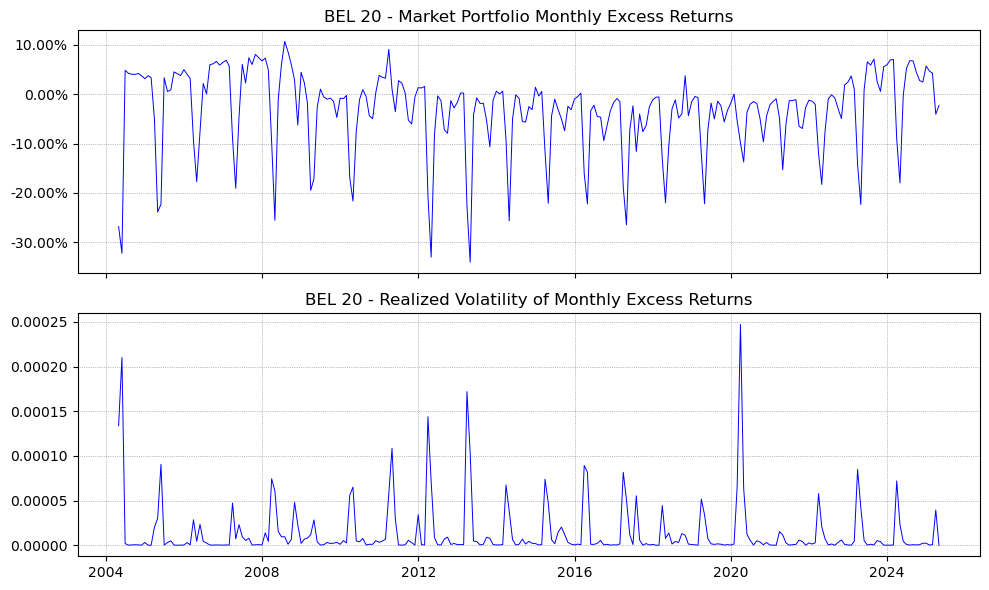

In [7]:
# Plotting the monthly returns and realized volatility for each index
for col in columns:
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Monthly Returns
    axes[0].plot(monthlty_Returns_Index_Futures.index, monthlty_Returns_Index_Futures[col], color='blue', linewidth=0.7)
    axes[0].set_title(f"{col} - Market Portfolio Monthly Excess Returns")
    axes[0].grid(True, linestyle=":", linewidth=0.5, color='grey')
    axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.2f}%'))

    # Realized Volatility or other data from RV
    axes[1].plot(RV.index, RV[col], color="blue", linewidth=0.7)
    axes[1].set_title(f"{col} - Realized Volatility of Monthly Excess Returns")
    axes[1].grid(True, linestyle=":", linewidth=0.5, color='grey')

    plt.tight_layout()
    plt.show()

<div class="alert alert-info">

Self Note: Add recession periods.

</div>